# Data PreProcessing

Data downloaded from: [GRData](http://grdata-grandrapids.opendata.arcgis.com/datasets/cgr-crash-data?geometry=-125.244%2C40.576%2C125.244%2C72.126).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.metrics import roc_curve, auc

In [107]:
crash = pd.read_csv('Data/CGR_Crash_Data.csv')
crash.head(4)

,X,Y,OBJECTID,ROADSOFTID,BIKE,CITY,CRASHDATE,CRASHSEVER,CRASHTYPE,WORKZNEACT,...,VEH3DIR,VEH3TYPE,VEH3USE,WEATHER,WHEREONRD,YEAR,RDCITYTWP,RDNUMLANES,RDWIDTH,FRAMEWORK
0,-85.639647,42.927216,6001,929923,No,Grand Rapids,2007-02-16,Property Damage Only,Side-Swipe Same,Uncoded & Errors,...,U,Uncoded & Errors,Uncoded & Errors,Cloudy,On the Road,2007,Grand Rapids,2,42.0,17
1,-85.639487,42.927213,6002,935745,No,Grand Rapids,2007-06-22,Property Damage Only,Side-Swipe Same,Uncoded & Errors,...,U,Uncoded & Errors,Uncoded & Errors,Clear,On the Road,2007,Grand Rapids,2,42.0,17
2,-85.639387,42.927212,6003,926813,No,Grand Rapids,2007-01-08,Property Damage Only,Head-on,Work on Shoulder / Median,...,U,Uncoded & Errors,Uncoded & Errors,Snow,On the Road,2007,Grand Rapids,2,42.0,17
3,-85.639288,42.927210,6004,943813,No,Grand Rapids,2007-11-12,Property Damage Only,Side-Swipe Same,Uncoded & Errors,...,U,Uncoded & Errors,Uncoded & Errors,Cloudy,On the Road,2007,Grand Rapids,2,42.0,17


In [108]:
#crash.DRIVER1AGE.value_counts()

In [109]:
initial_shape = crash.shape
print(initial_shape)

(72977, 77)


Thankfully, there is no blatantly missing data. Most places where data is missing, there is a short message like "Uncoded & Errors". We'll have to deal with this on a case by case basis.

## Columns Dropped
* Unfortunately, I do not know what the "OBJECTID" or "ROADSOFTID" columns mean, so I will drop them.
* Since all crashes occur in Grand Rapids, I will drop the "CITY" column.
* Since we have other features that may represent the time/date better than "CRASHDATE" we'll drop it.
* "WORKZNEACT", "WORKZNECLO", "WORKZNETYP", "ANIMAL" are primarily errors
* "DAYOFMONTH", "DAYOFWEEK" were fairly evenly distributed and did not seem to have any correlation with "HITANDRUN"
* Wanted to use "D1COND", "D2COND", "D3COND", but not enough data recorded.
* "FLEEINGSIT" looks like it could be helpful, but not sure what it means, and far too few instances
* all read no for "NONTRAFFIC"
* Such low amounts of data on Vehichle defect, dropped "V1DEFECT", "V2DEFECT"
* Such low amounts of data on any third vehicle, drop 'D3DRINKIN', 'DRIVER3AGE', 'DRIVER3SEX', 'V3DEFECT', 'V3DAMAGE', 'VEH3DIR', 'VEH3TYPE', 'VEH3USE'


* Drop all V3's

In [110]:
labels = ["OBJECTID", "ROADSOFTID", "CITY", "CRASHDATE", "WORKZNEACT", "WORKZNECLO", "WORKZNETYP",
         "DAYOFMONTH", "DAYOFWEEK", "ANIMAL", "D1COND", "D2COND", "D3COND", "FARMEQUIP", "FLEEINGSIT", "NONTRAFFIC", 
         "NUMOFKILL", "ORV", "PUBLICPROP", "PEDESTRIAN", "SNOWMOBILE", "SCHOOLBUS", "TRAIN", "V1DEFECT", "V2DEFECT", 
          'D3DRINKIN', 'DRIVER3AGE', 'DRIVER3SEX', 'V3DEFECT', 'V3DAMAGE', 'VEH3DIR', 'VEH3TYPE', 'VEH3USE',
          'FRAMEWORK', 'RDCITYTWP', 'YEAR'
         ]
crash = crash.drop(labels=labels, axis=1)

In [111]:
crash.head(4)

,X,Y,BIKE,CRASHSEVER,CRASHTYPE,D1DRINKIN,D2DRINKIN,DRIVER1AGE,DRIVER1SEX,DRIVER2AGE,...,VEH1DIR,VEH1TYPE,VEH1USE,VEH2DIR,VEH2TYPE,VEH2USE,WEATHER,WHEREONRD,RDNUMLANES,RDWIDTH
0,-85.639647,42.927216,No,Property Damage Only,Side-Swipe Same,No,No,62,F,999,...,W,"Passenger Car, SUV, Van",Private,U,Uncoded & Errors,Uncoded & Errors,Cloudy,On the Road,2,42.0
1,-85.639487,42.927213,No,Property Damage Only,Side-Swipe Same,No,No,31,M,999,...,E,"Passenger Car, SUV, Van",Private,E,Uncoded & Errors,Uncoded & Errors,Clear,On the Road,2,42.0
2,-85.639387,42.927212,No,Property Damage Only,Head-on,No,No,22,F,37,...,E,Pickup Truck,Private,W,"Passenger Car, SUV, Van",Private,Snow,On the Road,2,42.0
3,-85.639288,42.927210,No,Property Damage Only,Side-Swipe Same,No,No,30,M,999,...,E,Pickup Truck,Private,E,"Passenger Car, SUV, Van",Uncoded & Errors,Cloudy,On the Road,2,42.0


In [112]:
dropped_shape = crash.shape
print(dropped_shape)

(72977, 41)


In [113]:
crash.columns

Index(['X', 'Y', 'BIKE', 'CRASHSEVER', 'CRASHTYPE', 'D1DRINKIN', 'D2DRINKIN',
       'DRIVER1AGE', 'DRIVER1SEX', 'DRIVER2AGE', 'DRIVER2SEX', 'EMRGVEH',
       'GRTINJSEVE', 'HITANDRUN', 'HOUR', 'MONTH', 'MOTORCYCLE', 'NOATYPEINJ',
       'NOBTYPEINJ', 'NOCTYPEINJ', 'NUMOFINJ', 'NUMOFOCCUP', 'NUMOFUNINJ',
       'NUMOFVEHIC', 'SPDLMTPOST', 'SPEEDLIMIT', 'SURFCOND', 'TRAFCTLDEV',
       'TRUCKBUS', 'V1DAMAGE', 'V2DAMAGE', 'VEH1DIR', 'VEH1TYPE', 'VEH1USE',
       'VEH2DIR', 'VEH2TYPE', 'VEH2USE', 'WEATHER', 'WHEREONRD', 'RDNUMLANES',
       'RDWIDTH'],
      dtype='object')

## Getting Rid of Errors

### Categorical Variables

In [114]:
print(crash[crash.columns[6]].value_counts())

No                  62819
Uncoded & Errors     9639
Yes                   519
Name: D2DRINKIN, dtype: int64


In [115]:
errors_dict = {'D2DRINKIN': 'Uncoded & Errors', "DRIVER1SEX": "U", "SPDLMTPOST": 'Uncoded & Errors', 'SURFCOND': ('Uncoded & Errors', 'Unknown'),
         'TRAFCTLDEV': 'Uncoded & Errors', 'V1DAMAGE': ('Uncoded & Errors', 'Unknown'), 'V2DAMAGE': ('Uncoded & Errors', 'Unknown'),
         'VEH1DIR': 'U', 'VEH1TYPE': 'Uncoded & Errors', 'VEH1USE': 'Uncoded & Errors',
         'VEH2DIR': 'U', 'VEH2TYPE': 'Uncoded & Errors', 'VEH2USE': 'Uncoded & Errors', 'WEATHER': 'Unknown', 
          'WHEREONRD': ('Unknown', 'Uncoded & Errors')}
# Maybe make a classifier to fill in the "U" in the "DRIVER1/2SEX" column?
# May have to delete some outliers in "NUMOFOCCUP", and "NUMOFUNINJ", and "SPEEDLIMIT, 
# For "V1/2DAMAGE", maybe assumer that uncoded means no damage?

* **D2DRINKIN**: It is safe to assume that if driver 2 was intoxicated, they would indicate it. For that reason, we fill the uncoded rows with "No".

In [116]:
crash['D2DRINKIN'] = crash['D2DRINKIN'].replace('Uncoded & Errors', 'No')
crash['D2DRINKIN'].value_counts()

No     72458
Yes      519
Name: D2DRINKIN, dtype: int64

* **DRIVER1SEX**,  **DRIVER2SEX**: For the time being, I will leave the "Unknown" rows alone, allowing them to be a separate gender. If this seems to be causing issues, I may need fit a classifier to predict gender. This may be a tricky missing value to handle because there are thousands of unknowns.

In [117]:
crash['DRIVER1SEX'].value_counts()

M    35513
F    30075
U     7389
Name: DRIVER1SEX, dtype: int64

* **SPDLMTPOST**: Since there is such a small amount of errors, it is safe to say that the speed limit was most likely not posted there.

In [118]:
crash['SPDLMTPOST'] = crash['SPDLMTPOST'].replace('Uncoded & Errors', 'No')
crash['SPDLMTPOST'].value_counts()

Yes    54384
No     18593
Name: SPDLMTPOST, dtype: int64

* **SURFCOND**: Since there are so few features, we will put "other", "Errors", and "Unknown" in the same bin.

In [119]:
crash['SURFCOND'] = crash['SURFCOND'].replace(to_replace = ['Unknown', 'Uncoded & Errors'], value = 'No')
crash['SURFCOND'].value_counts()

Dry                  45433
Wet                  14069
Snowy                 6183
Icy                   5270
Slush                 1040
Other                  722
No                     209
Debris                  31
Mud, Dirt, Gravel       16
Water                    4
Name: SURFCOND, dtype: int64

* **TRAFCTLDEV**: This is a tough call, but for the time being, I'll replace "Errors" with the most frequent value in this feature, "None".

In [120]:
crash['TRAFCTLDEV'] = crash['TRAFCTLDEV'].replace(to_replace = 'Uncoded & Errors', value = crash['TRAFCTLDEV'].mode()[0])
crash['TRAFCTLDEV'].value_counts()

None                              42342
Signal                            20902
Stop Sign                          8741
Yield Sign                          973
Stop Sign with Flashing Beacon       19
Name: TRAFCTLDEV, dtype: int64

* **V1DAMAGE, V2DAMAGE**: Will put "Errors" and "Unknown" into the same bin.

In [121]:
crash['V1DAMAGE'] = crash['V1DAMAGE'].replace('Uncoded & Errors', 'Unknown')
crash['V1DAMAGE'].value_counts()
crash['V2DAMAGE'] = crash['V2DAMAGE'].replace('Uncoded & Errors', 'Unknown')
crash['V2DAMAGE'].value_counts()

Minor Damage         34828
Unknown              15602
Disabling Damage     13331
Functional Damage     8645
No Damage              571
Name: V2DAMAGE, dtype: int64

* **VEH1DIR, VEH2DIR**: Since there are so many "Unknown" at the moment, may leave it as it's own direction for the time being. Merge the double directions (SE, NW, etc) into their primary direction, since there are so few of them.
    * Note: There are far more "Unknown" for vehicle 2 than for vehicle 1

In [122]:
crash['VEH1DIR'] = crash['VEH1DIR'].replace(to_replace = ['NE', 'NW'], value = 'N')
crash['VEH1DIR'] = crash['VEH1DIR'].replace(to_replace = ['SE', 'SW'], value = 'S')

crash['VEH2DIR'] = crash['VEH2DIR'].replace(to_replace = ['NE', 'NW'], value = 'N')
crash['VEH2DIR'] = crash['VEH2DIR'].replace(to_replace = ['SE', 'SW'], value = 'S')

crash['VEH1DIR'].value_counts()

N    18528
W    17789
S    17404
E    17273
U     1983
Name: VEH1DIR, dtype: int64

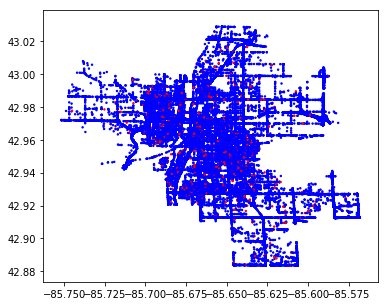

In [123]:
# all "Unknown" Direction crashes
fig, ax = plt.subplots(figsize=(6,5))

colors = {'U':'red', 'N':'blue', 'W':'blue', 'S':'blue', 'E':'blue', 'SE':'blue', 'SW':'blue', 'NW': 'blue', 'NE':'blue'}

ax.scatter(crash.X, crash.Y, c=crash.VEH1DIR.apply(lambda x: colors[x]), s=2)

plt.show()

* **VEH1TYPE, VEH2TYPE**: Tough call, but will impute the most frequent values in for these two types. Also, there are so few off-road and go-cart instnaces that I will bin these with "Other Non-Commercial"

In [124]:
crash['VEH1TYPE'] = crash['VEH1TYPE'].replace(to_replace = ['Go-cart / Golf Cart', 'Off-Road Vehicle, All-Terrain Vehicle'], 
                                              value = 'Other Non-Commercial')
crash['VEH1TYPE'] = crash['VEH1TYPE'].replace(to_replace = 'Uncoded & Errors', value = crash['VEH1TYPE'].mode()[0])

crash['VEH2TYPE'] = crash['VEH1TYPE'].replace(to_replace = ['Go-cart / Golf Cart', 'Off-Road Vehicle, All-Terrain Vehicle'], 
                                              value = 'Other Non-Commercial')
crash['VEH2TYPE'] = crash['VEH2TYPE'].replace(to_replace = 'Uncoded & Errors', value = crash['VEH2TYPE'].mode()[0])

crash['VEH1TYPE'].value_counts()

Passenger Car, SUV, Van     59732
Pickup Truck                 6075
Motorhome                    4099
Truck / Bus (Commercial)     1564
Truck Under 10,000 lbs        799
Motorcycle                    470
Other Non-Commercial          127
Moped                         111
Name: VEH1TYPE, dtype: int64

* **VEH1USE, VEH2USE**: Another tough call. Will impute the most frequent.

In [125]:
crash['VEH1USE'] = crash['VEH1USE'].replace(to_replace = 'Uncoded & Errors', value = crash['VEH1USE'].mode()[0])
crash['VEH2USE'] = crash['VEH2USE'].replace(to_replace = 'Uncoded & Errors', value = crash['VEH2USE'].mode()[0])
crash['VEH1USE'].value_counts()

Private                             68760
Commercial                           3068
Other Government, Non-Emergency       459
School or Education                   215
Other                                 160
Club or Church                         91
In Pursuit or Emergency (in use)       81
Road Construction or Maintenance       69
Utility                                45
Farm                                   16
Military Vehicle                       13
Name: VEH1USE, dtype: int64

* **WEATHER**: Not many errors. Will impute the most frequent.

In [126]:
crash['WEATHER'] = crash['WEATHER'].replace(to_replace = 'Uncoded & Errors', value = crash['WEATHER'].mode()[0])
crash['WEATHER'].value_counts()

Clear               35846
Cloudy              20168
Snow                 8125
Rain                 7477
Unknown               905
Sleet or Hail         206
Fog                   139
Severe Crosswind       79
Blowing Snow           30
Smoke                   2
Name: WEATHER, dtype: int64

* **WHEREONRD**: Bin "Unknown" and "Errors" with most frequent.

In [127]:
crash['WHEREONRD'] = crash['WHEREONRD'].replace(to_replace = ['Uncoded & Errors', 'Unknown'], value = crash['WHEREONRD'].mode()[0])
crash['WHEREONRD'].value_counts()

On the Road                    66081
Outside of Shoulder or Curb     2986
On the Shoulder                 2886
In the Median                    637
In the Gore                      208
On-Street Parking                163
Sidewalk                          12
Bicycle Lane                       4
Name: WHEREONRD, dtype: int64

### Numerical Variables

 The following are the numerical variables that we must deal with: 
 ['DRIVER1AGE',
 'DRIVER2AGE',
 'NOATYPEINJ',
 'NOBTYPEINJ',
 'NOCTYPEINJ',
 'NUMOFINJ',
 'NUMOFOCCUP',
 'NUMOFUNINJ',
 'NUMOFVEHIC',
 'SPEEDLIMIT',
 'RDNUMLANES',
 'RDWIDTH']

* **DRIVER1AGE, DRIVER1AGE**: There are over 10,000 Driver ages listed as 999. I believe that this is an error and will replace these values with a random number around their mean. I admit that this seems pretty risky. Since there are so many, I'm tempted to fit a regressor to predict each age. I may have to come back and do this.

[This Stackoverflow thread](https://stackoverflow.com/questions/46543060/how-to-replace-every-nan-in-a-column-with-different-random-values-using-pandas) helped me out.

In [128]:
# Look over this and try it again soon.
'''
temp_age1 = crash.DRIVER1AGE[crash.DRIVER1AGE < 100]
temp_age2 = crash.DRIVER2AGE[crash.DRIVER2AGE < 100]

median = temp_age1.median()
std = temp_age2.std()

np.random.seed(0)

def fill_missing_from_Gaussian(column_val):
    if column_val == 999: 
        column_val = np.round(np.random.normal(median, std, 1))[0]
    else:
         column_val = column_val
    return column_val

crash['DRIVER1AGE'] = crash['DRIVER1AGE'].apply(fill_missing_from_Gaussian)
crash['DRIVER2AGE'] = crash['DRIVER2AGE'].apply(fill_missing_from_Gaussian)
'''
# Fill in missing values with same proportion as the ages that are filled in correctly

"\ntemp_age1 = crash.DRIVER1AGE[crash.DRIVER1AGE < 100]\ntemp_age2 = crash.DRIVER2AGE[crash.DRIVER2AGE < 100]\n\nmedian = temp_age1.median()\nstd = temp_age2.std()\n\nnp.random.seed(0)\n\ndef fill_missing_from_Gaussian(column_val):\n    if column_val == 999: \n        column_val = np.round(np.random.normal(median, std, 1))[0]\n    else:\n         column_val = column_val\n    return column_val\n\ncrash['DRIVER1AGE'] = crash['DRIVER1AGE'].apply(fill_missing_from_Gaussian)\ncrash['DRIVER2AGE'] = crash['DRIVER2AGE'].apply(fill_missing_from_Gaussian)\n"

In [129]:
temp_age1 = crash.DRIVER1AGE[crash.DRIVER1AGE < 100]
temp_age2 = crash.DRIVER2AGE[crash.DRIVER2AGE < 100]

crash['DRIVER1AGE'] = crash['DRIVER1AGE'].replace(to_replace = 999, value = temp_age1.median())
crash['DRIVER2AGE'] = crash['DRIVER2AGE'].replace(to_replace = 999, value = temp_age2.median())

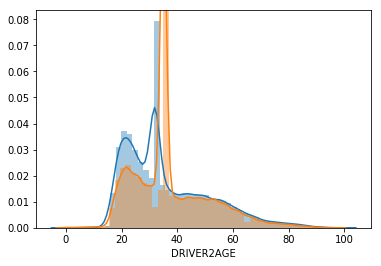

In [130]:
# Distribution of the driver's age's.
# Not sure that this was the best call, so may come back to it.
sns.distplot(crash['DRIVER1AGE'])
sns.distplot(crash['DRIVER2AGE'])

## Encoding Categorical Variables

## Scaling numerical variables:

[Here's an explanation](https://stats.stackexchange.com/questions/290958/logistic-regression-and-scaling-of-features) for why you should scale numerical variables in logistic regression

[Great discussion](https://stats.stackexchange.com/questions/164542/is-time-of-the-day-predictor-in-regression-a-categorical-or-a-continuous-varia) on how to deal with the "HOUR" Feature. [Here's another, with code examples](https://datascience.stackexchange.com/questions/5990/what-is-a-good-way-to-transform-cyclic-ordinal-attributes)
* Since "HOUR" doesn't really fit as a numerical or categorical variable, we are going do use a custom trigonometic transformation, mapping the single hour to two separate "HOUR_X" and "HOUR_Y" coordinates in order to capture the cyclic nature of hours in a day.

In [131]:
crash['HOUR_X']=np.sin(2. * np.pi * crash.HOUR / 24.)
crash['HOUR_Y']=np.cos(2. * np.pi * crash.HOUR / 24.)

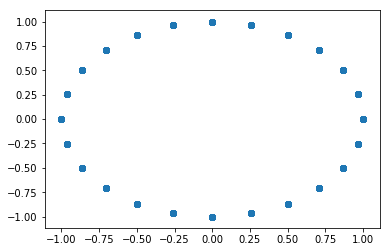

In [132]:
# Hence, the time of day is now cyclic (just as in reality)
plt.scatter(crash.HOUR_X, crash.HOUR_Y)

In [133]:
# Now that we have our two 'HOUR_X' and 'HOUR_Y' coords, we drop the original "HOUR" feature
crash = crash.drop(['HOUR'], axis=1)

In [134]:
cols = list(crash.columns)
cat_cols = ['BIKE', 'CRASHSEVER', 'CRASHTYPE', 'D1DRINKIN', 'D2DRINKIN', 'DRIVER1SEX', 'DRIVER2SEX',
                               'EMRGVEH','GRTINJSEVE', 'MONTH', "MOTORCYCLE", 'SPDLMTPOST', 'SURFCOND', 'TRAFCTLDEV',
                               'TRUCKBUS', 'V1DAMAGE', 'V2DAMAGE', 'VEH1DIR', 'VEH1TYPE', 'VEH1USE',
                               'VEH2DIR', 'VEH2TYPE', 'VEH2USE', 'WEATHER', 'WHEREONRD']
num_cols = []
for i in cols:
    if i not in cat_cols:
        num_cols.append(i)
num_cols.remove('HITANDRUN')

In [135]:
num_cols.remove('X')
num_cols.remove('Y')
num_cols.remove('HOUR_X')
num_cols.remove('HOUR_Y')
num_cols # These are the columns that must be scaled

['DRIVER1AGE',
 'DRIVER2AGE',
 'NOATYPEINJ',
 'NOBTYPEINJ',
 'NOCTYPEINJ',
 'NUMOFINJ',
 'NUMOFOCCUP',
 'NUMOFUNINJ',
 'NUMOFVEHIC',
 'SPEEDLIMIT',
 'RDNUMLANES',
 'RDWIDTH']

## Stitching Together Data and Preparing to model

In [136]:
y = crash.HITANDRUN
lbl = LabelEncoder()
y = lbl.fit_transform(y)
y

array([1, 1, 0, ..., 0, 0, 0])

Use [this technique](https://github.com/JWarmenhoven/ISLR-python/blob/master/Notebooks/Chapter%206.ipynb)

In [137]:
dummies = pd.get_dummies(crash[['BIKE', 'CRASHSEVER', 'CRASHTYPE', 'D1DRINKIN', 'D2DRINKIN', 'DRIVER1SEX', 'DRIVER2SEX',
                               'EMRGVEH','GRTINJSEVE', 'MONTH', "MOTORCYCLE", 'SPDLMTPOST', 'SURFCOND', 'TRAFCTLDEV',
                               'TRUCKBUS', 'V1DAMAGE', 'V2DAMAGE', 'VEH1DIR', 'VEH1TYPE', 'VEH1USE',
                               'VEH2DIR', 'VEH2TYPE', 'VEH2USE', 'WEATHER', 'WHEREONRD']])

In [138]:
dummies.head()

,BIKE_No,BIKE_Yes,CRASHSEVER_Fatal,CRASHSEVER_Injury,CRASHSEVER_Property Damage Only,CRASHTYPE_Angle Driveway,CRASHTYPE_Angle Straight,CRASHTYPE_Angle Turn,CRASHTYPE_Animal,CRASHTYPE_Backing,...,WEATHER_Snow,WEATHER_Unknown,WHEREONRD_Bicycle Lane,WHEREONRD_In the Gore,WHEREONRD_In the Median,WHEREONRD_On the Road,WHEREONRD_On the Shoulder,WHEREONRD_On-Street Parking,WHEREONRD_Outside of Shoulder or Curb,WHEREONRD_Sidewalk
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [139]:
# Drop the column with target variable (HITANDRUN) and the columns for which we created dummy variables
X_ = crash.drop(['HITANDRUN', 'BIKE', 'CRASHSEVER', 'CRASHTYPE', 'D1DRINKIN', 'D2DRINKIN', 'DRIVER1SEX', 'DRIVER2SEX',
                               'EMRGVEH','GRTINJSEVE', 'MONTH', "MOTORCYCLE", 'SPDLMTPOST', 'SURFCOND', 'TRAFCTLDEV',
                               'TRUCKBUS', 'V1DAMAGE', 'V2DAMAGE', 'VEH1DIR', 'VEH1TYPE', 'VEH1USE',
                               'VEH2DIR', 'VEH2TYPE', 'VEH2USE', 'WEATHER', 'WHEREONRD'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72977 entries, 0 to 72976
Columns: 170 entries, X to WHEREONRD_Sidewalk
dtypes: float64(16), uint8(154)
memory usage: 19.6 MB


In [140]:
cols_to_scale = num_cols
cols_to_scale

['DRIVER1AGE',
 'DRIVER2AGE',
 'NOATYPEINJ',
 'NOBTYPEINJ',
 'NOCTYPEINJ',
 'NUMOFINJ',
 'NUMOFOCCUP',
 'NUMOFUNINJ',
 'NUMOFVEHIC',
 'SPEEDLIMIT',
 'RDNUMLANES',
 'RDWIDTH']

In [141]:
X.head()

,X,Y,DRIVER1AGE,DRIVER2AGE,NOATYPEINJ,NOBTYPEINJ,NOCTYPEINJ,NUMOFINJ,NUMOFOCCUP,NUMOFUNINJ,...,WEATHER_Snow,WEATHER_Unknown,WHEREONRD_Bicycle Lane,WHEREONRD_In the Gore,WHEREONRD_In the Median,WHEREONRD_On the Road,WHEREONRD_On the Shoulder,WHEREONRD_On-Street Parking,WHEREONRD_Outside of Shoulder or Curb,WHEREONRD_Sidewalk
0,-85.639647,42.927216,62.0,35.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0
1,-85.639487,42.927213,31.0,35.0,0.0,0.0,0.0,0.0,3.0,3.0,...,0,0,0,0,0,1,0,0,0,0
2,-85.639387,42.927212,22.0,37.0,0.0,0.0,0.0,0.0,2.0,2.0,...,1,0,0,0,0,1,0,0,0,0
3,-85.639288,42.927210,30.0,35.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0
4,-85.639288,42.927210,44.0,35.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0


## Scaling where necessary

In [142]:
sc_X = StandardScaler()
X_scaled = sc_X.fit_transform(X[['DRIVER1AGE', 'DRIVER2AGE', 'NOATYPEINJ', 'NOBTYPEINJ', 'NOCTYPEINJ','NUMOFINJ', 
                                             'NUMOFOCCUP', 'NUMOFUNINJ', 'NUMOFVEHIC', 'SPEEDLIMIT', 'RDNUMLANES', 'RDWIDTH']])

In [143]:
X_scaled_df = pd.DataFrame(X_scaled, columns=['DRIVER1AGE', 'DRIVER2AGE', 'NOATYPEINJ', 'NOBTYPEINJ', 'NOCTYPEINJ','NUMOFINJ', 
                                             'NUMOFOCCUP', 'NUMOFUNINJ', 'NUMOFVEHIC', 'SPEEDLIMIT', 'RDNUMLANES', 'RDWIDTH'])

In [144]:
X_= X.drop(['DRIVER1AGE', 'DRIVER2AGE', 'NOATYPEINJ', 'NOBTYPEINJ', 'NOCTYPEINJ','NUMOFINJ', 
                        'NUMOFOCCUP', 'NUMOFUNINJ', 'NUMOFVEHIC', 'SPEEDLIMIT', 'RDNUMLANES', 'RDWIDTH'], axis=1)

In [145]:
X = pd.concat([X_scaled_df, X_], axis=1)

In [146]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72977 entries, 0 to 72976
Columns: 170 entries, DRIVER1AGE to WHEREONRD_Sidewalk
dtypes: float64(16), uint8(154)
memory usage: 19.6 MB


In [147]:
X.head()

,DRIVER1AGE,DRIVER2AGE,NOATYPEINJ,NOBTYPEINJ,NOCTYPEINJ,NUMOFINJ,NUMOFOCCUP,NUMOFUNINJ,NUMOFVEHIC,SPEEDLIMIT,...,WEATHER_Snow,WEATHER_Unknown,WHEREONRD_Bicycle Lane,WHEREONRD_In the Gore,WHEREONRD_In the Median,WHEREONRD_On the Road,WHEREONRD_On the Shoulder,WHEREONRD_On-Street Parking,WHEREONRD_Outside of Shoulder or Curb,WHEREONRD_Sidewalk
0,1.686190,-0.171915,-0.100741,-0.186046,-0.372068,-0.416816,-0.625891,-0.519288,0.11077,-0.484432,...,0,0,0,0,0,1,0,0,0,0
1,-0.333478,-0.171915,-0.100741,-0.186046,-0.372068,-0.416816,0.309367,0.420199,0.11077,-0.484432,...,0,0,0,0,0,1,0,0,0,0
2,-0.919833,-0.022396,-0.100741,-0.186046,-0.372068,-0.416816,-0.158262,-0.049545,0.11077,-0.484432,...,1,0,0,0,0,1,0,0,0,0
3,-0.398628,-0.171915,-0.100741,-0.186046,-0.372068,-0.416816,-0.625891,-0.519288,0.11077,-0.484432,...,0,0,0,0,0,1,0,0,0,0
4,0.513480,-0.171915,-0.100741,-0.186046,-0.372068,-0.416816,-0.625891,-0.519288,0.11077,-0.484432,...,0,0,0,0,0,0,1,0,0,0


# Export to CSV

In [149]:
X.to_csv('Data/Crash_X.csv', index=False)
pd.DataFrame(y).to_csv('Data/Crash_y.csv', index=False)